   Age     Sex     BMI  Children Smoker     Region     Charges  \
0   19  female  27.900         0    yes  southwest  16884.9240   
1   18    male  33.770         1     no  southeast   1725.5523   
2   28    male  33.000         3     no  southeast   4449.4620   
3   33    male  22.705         0     no  northwest  21984.4706   
4   32    male  28.880         0     no  northwest   3866.8552   

  Chronic_Condition Physical_Activity_Level Previous_Medical_Costs  \
0               yes                  Active                  $2500   
1                no               Sedentary                   $400   
2                no                Moderate                  $1000   
3                no                  Active                  $3000   
4                no                Moderate                   $250   

  Smoking_Duration Family_History       Occupation  Healthcare_Cost_Index  \
0                5             no          student                    1.2   
1                0          

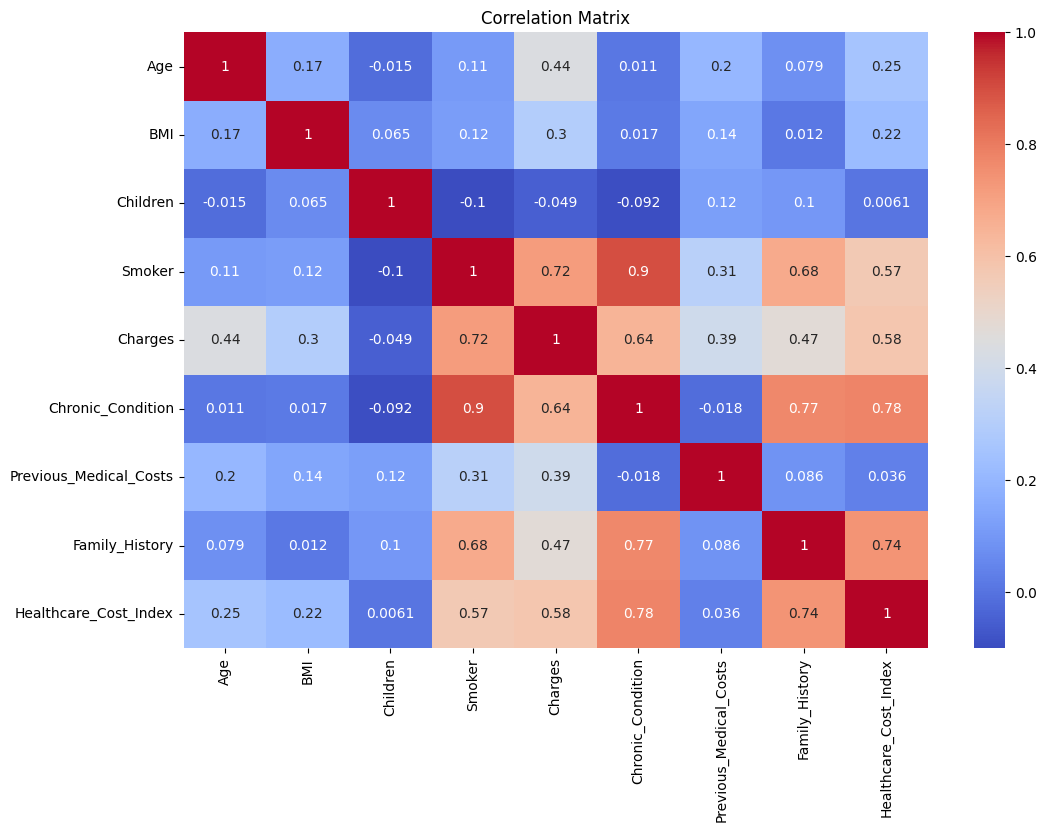

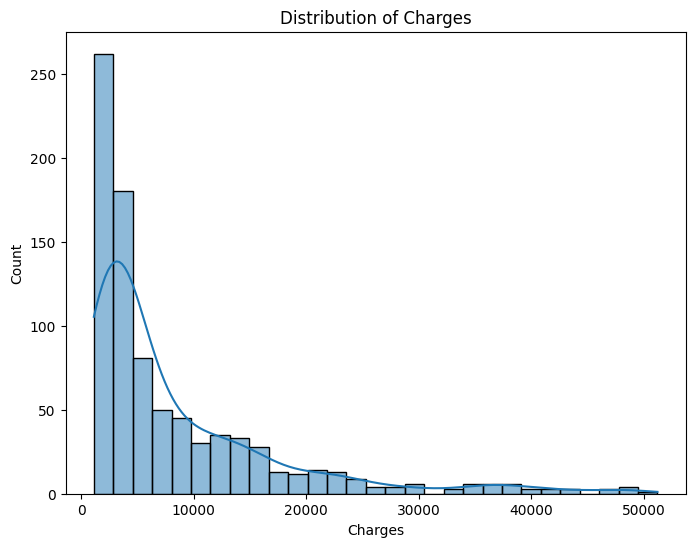

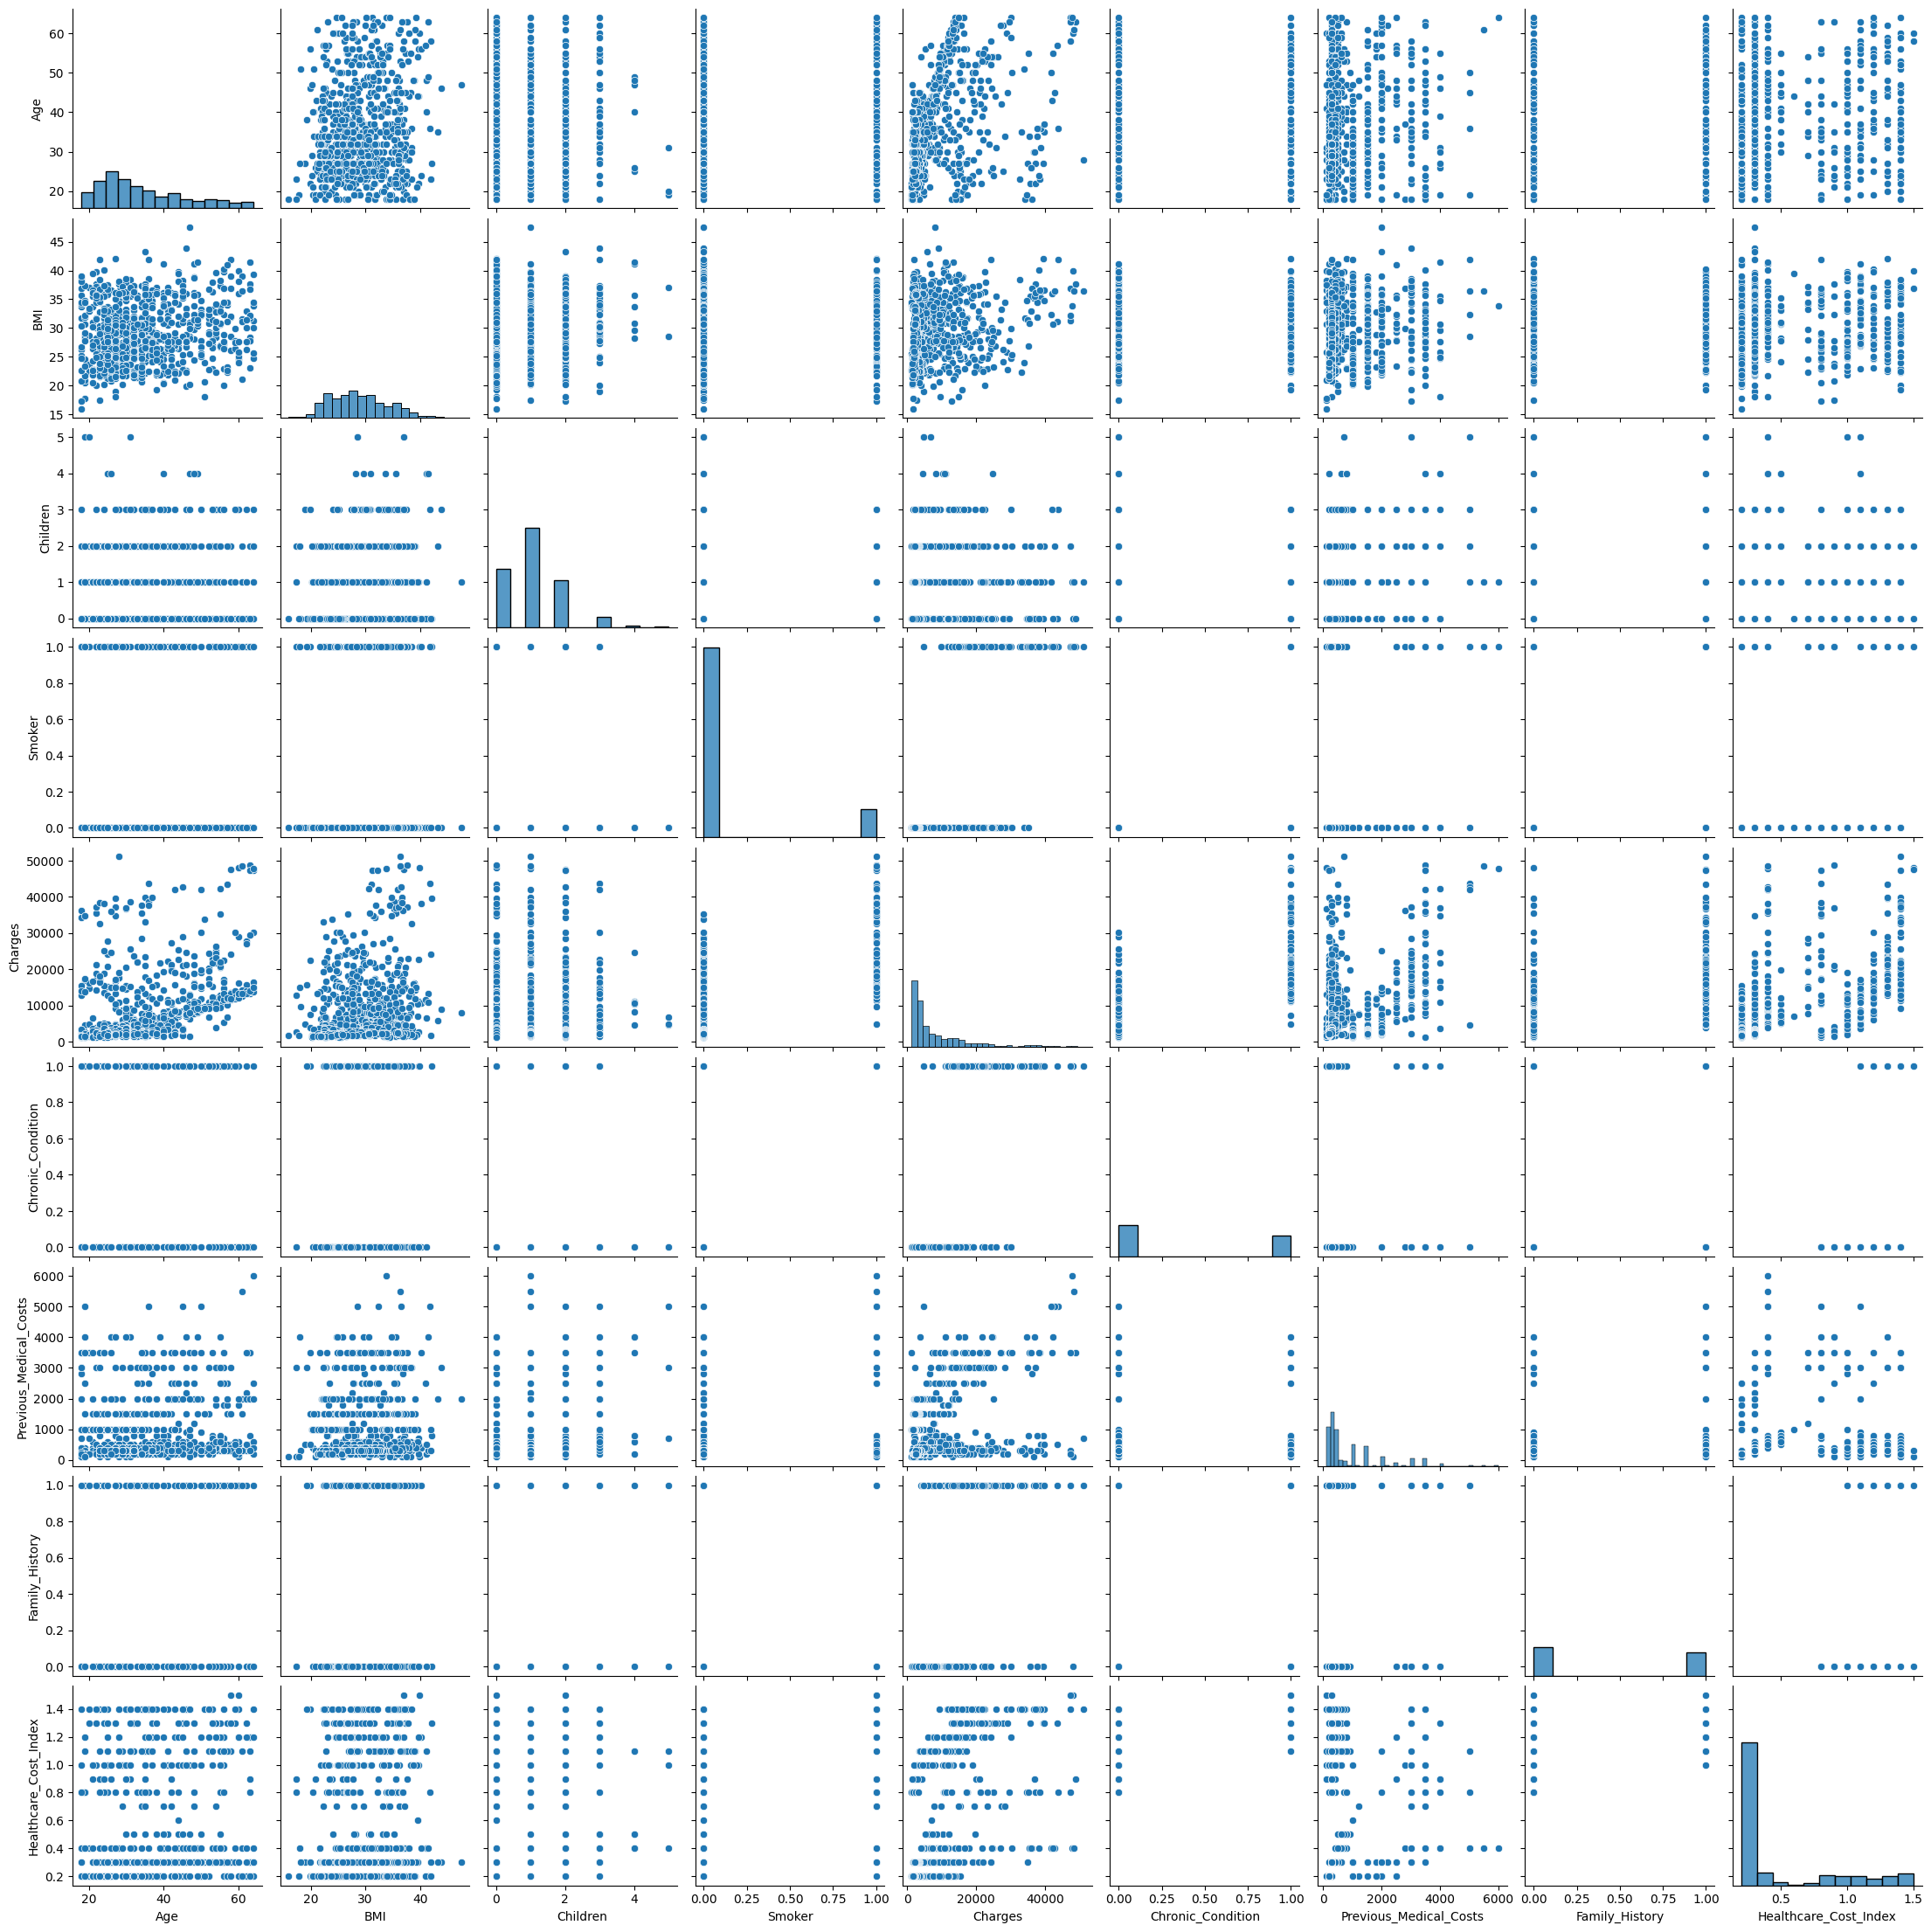

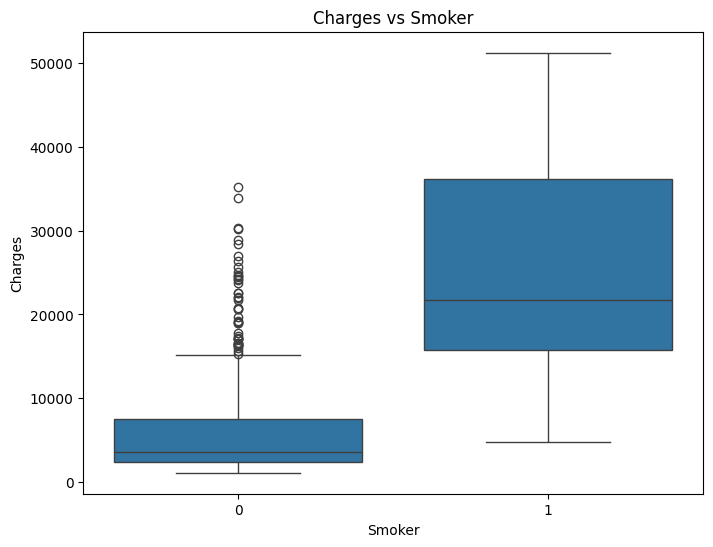

Correlation of features with Charges:
 Charges                   1.000000
Smoker                    0.717658
Chronic_Condition         0.643689
Healthcare_Cost_Index     0.582264
Family_History            0.469404
Age                       0.438556
Previous_Medical_Costs    0.390157
BMI                       0.296498
Children                 -0.049020
Name: Charges, dtype: float64
Best Ridge Model Parameters: {'alpha': 10.0, 'solver': 'lsqr'}
Ridge Regression - MSE: 32466995.869579557, RMSE: 5697.9817365080735, MAE: 3698.6483053764996, R²: 0.7152836210234024
Best Random Forest Model Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Random Forest - MSE: 17926282.000859547, RMSE: 4233.944024294552, MAE: 2101.853296020364, R²: 0.8427970939996863


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv('/content/medical insurance data.csv')

# Inspect the first few rows
print(df.head())

# Display basic information about the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Drop 'Unnamed: 15' since it contains NaN values and is not relevant
df = df.drop(columns=['Unnamed: 15'])

# Ensure binary categorical columns are converted to 0/1
df['Chronic_Condition'] = df['Chronic_Condition'].map({'yes': 1, 'no': 0})
df['Family_History'] = df['Family_History'].map({'yes': 1, 'no': 0})
df['Smoker'] = df['Smoker'].map({'yes': 1, 'no': 0})
# Remove dollar signs and commas, then convert to float
df['Previous_Medical_Costs'] = df['Previous_Medical_Costs'].replace('[\$,]', '', regex=True).astype(float)


# Handle missing values (There were no NaNs in 'Previous_Medical_Costs' based on the dataset)
df['Previous_Medical_Costs'] = df['Previous_Medical_Costs'].fillna(df['Previous_Medical_Costs'].median())

# Handle missing values in the target variable 'Charges'
df['Charges'] = df['Charges'].fillna(df['Charges'].median())

# Select only the numeric columns for the correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Distribution of charges
plt.figure(figsize=(8, 6))
sns.histplot(df['Charges'], kde=True)
plt.title('Distribution of Charges')
plt.show()

# Pairplot to see relationships between numerical features
sns.pairplot(numeric_df)
plt.show()

# Boxplot to visualize the impact of smoking on charges
plt.figure(figsize=(8, 6))
sns.boxplot(x='Smoker', y='Charges', data=df)
plt.title('Charges vs Smoker')
plt.show()

# Correlation of features with the target (Charges)
correlation = numeric_df.corr()['Charges'].sort_values(ascending=False)
print("Correlation of features with Charges:\n", correlation)

# Select features with high correlation to Charges
selected_features = ['Age', 'BMI', 'Smoker', 'Chronic_Condition', 'Previous_Medical_Costs', 'Healthcare_Cost_Index']

# Prepare X and y for modeling
X = df[selected_features]
y = df['Charges']

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), selected_features),
    ])

# Preprocessing for numerical data
X_processed = preprocessor.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 1. Ridge Regression with Hyperparameter Tuning
ridge = Ridge()

param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag']
}

grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, cv=5, scoring='r2')
grid_search_ridge.fit(X_train, y_train)

best_ridge_model = grid_search_ridge.best_estimator_
print("Best Ridge Model Parameters:", grid_search_ridge.best_params_)

# Predict and evaluate the Ridge model
y_pred_ridge = best_ridge_model.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'Ridge Regression - MSE: {mse_ridge}, RMSE: {rmse_ridge}, MAE: {mae_ridge}, R²: {r2_ridge}')

# 2. Random Forest Regressor with Hyperparameter Tuning
rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
print("Best Random Forest Model Parameters:", grid_search_rf.best_params_)

# Predict and evaluate the Random Forest model
y_pred_rf = best_rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest - MSE: {mse_rf}, RMSE: {rmse_rf}, MAE: {mae_rf}, R²: {r2_rf}')



In [ ]:
import joblib

# Save models
joblib.dump(best_ridge_model, 'ridge_model.pkl')
joblib.dump(best_rf_model, 'rf_model.pkl')


['rf_model.pkl']